In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from itertools import combinations
from xgboost import XGBClassifier
import pickle
import re
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
from pycaret.classification import setup, compare_models, create_model, tune_model, plot_model, evaluate_model, finalize_model, predict_model, save_model, load_model

from feature_engine.creation import MathFeatures
from feature_engine.encoding import OneHotEncoder, RareLabelEncoder
from feature_engine.imputation import MeanMedianImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split
from pycaret.classification import predict_model, finalize_model, get_config, create_model
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
path = "C:/Users/jesco/OneDrive - Universidad Santo Tomás/Documentos/Python/T3/"

In [10]:
%%time
df = pd.read_csv(path  + 'data/train.csv')
prueba = pd.read_csv(path + "data/test.csv")

# Separar la columna 'id' antes de las transformaciones
prueba_id = prueba["id"]
df_id = df["id"]

# Eliminar la columna 'id' antes de las transformaciones
prueba = prueba.drop(columns=["id"])
df = df.drop(columns=["id"])

CPU times: total: 203 ms
Wall time: 333 ms


In [11]:
# ct = ['Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor',
#       'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International', 'Marital status',
#      'Application mode', 'Application order', 'Course', 'Previous qualification', 'Nacionality',
#      "Mother's qualification", "Father's qualification", "Mother's occupation",
#      "Father's occupation", ]

ct = ['Gender', 'Displaced', 'Educational special needs', 'Debtor', 'Scholarship holder', 
      'International', 'Marital status', 'Nacionality', "Mother's occupation", "Father's occupation"]

for k in ct:
  df[k] = df[k].astype("O")
  prueba[k] = prueba[k].astype("O")

## Datos Faltantes

In [12]:
from main import analizar_faltantes

# Uso de la función para 'df'
faltantes_df = analizar_faltantes(df)
print(faltantes_df)

# Uso de la función para 'prueba'
faltantes_prueba = analizar_faltantes(prueba)
print(faltantes_prueba)

Empty DataFrame
Columns: [Variable, Faltantes, % Faltantes]
Index: []
Empty DataFrame
Columns: [Variable, Faltantes, % Faltantes]
Index: []


## Análisis descriptivo

In [13]:
df.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd s

In [14]:
# Selección de variables cuantitativas, excluyendo 'id' y 'Target'
cuantitativas = df.select_dtypes(exclude='O').columns.tolist()
cuantitativas = [x for x in cuantitativas if x not in ['id', 'Target']]

In [15]:
# Selección de variables categoricas, excluyendo 'id' y 'Target'
categoricas = df.select_dtypes(include=['object', 'category']).columns.tolist()
categoricas = [x for x in categoricas if x not in ['id', 'Target']]

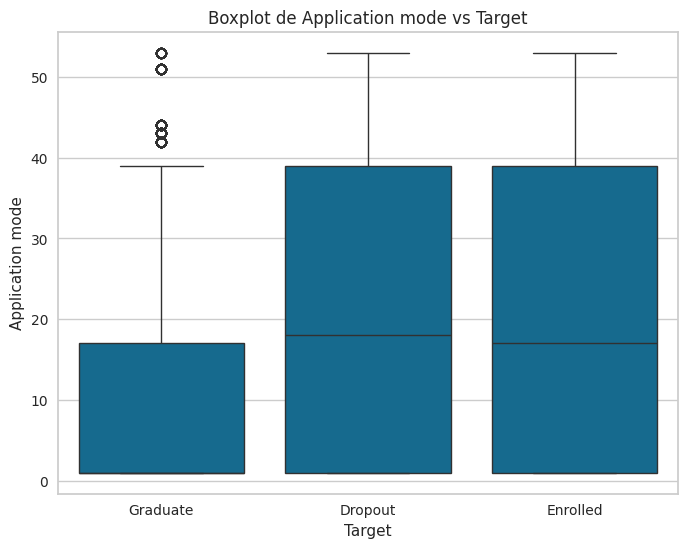

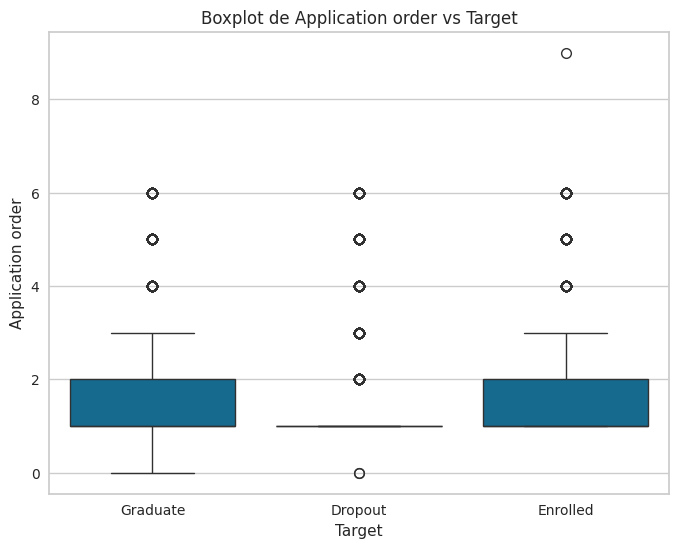

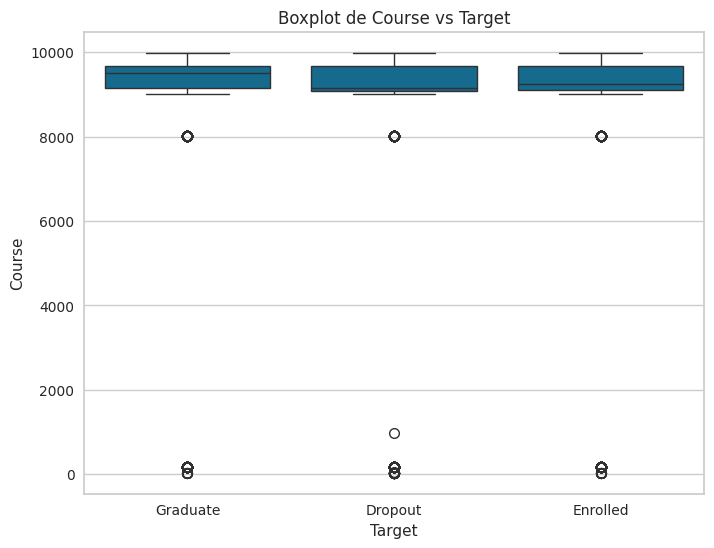

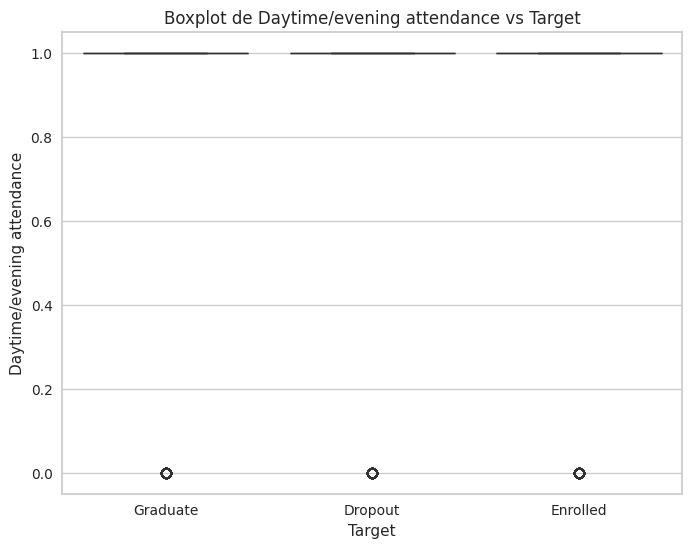

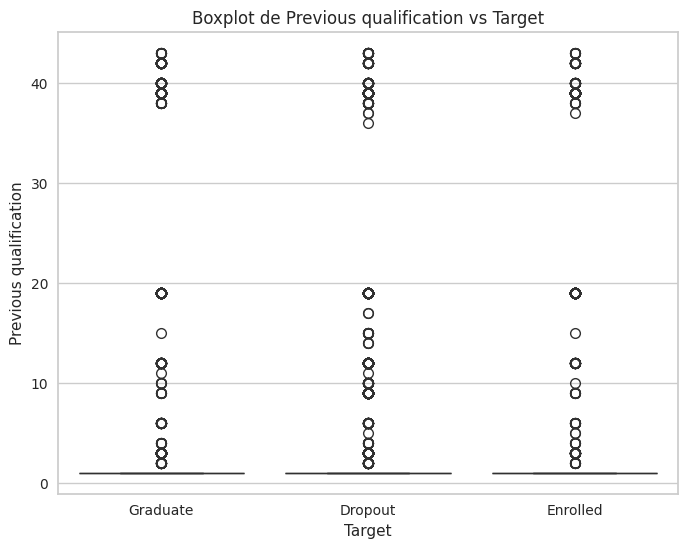

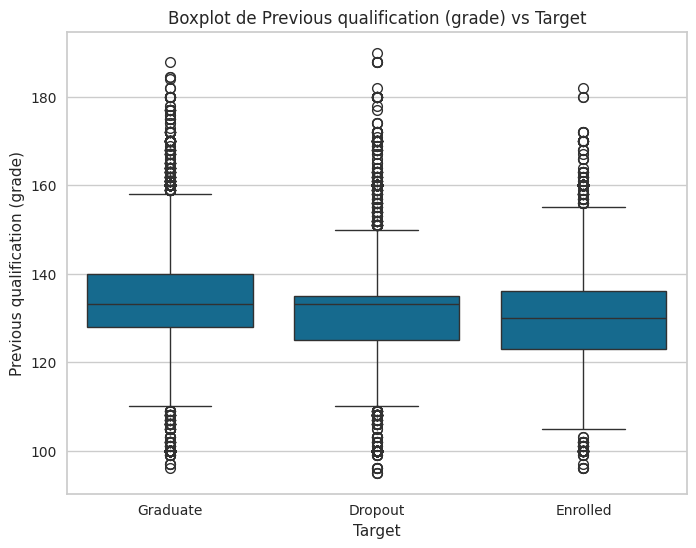

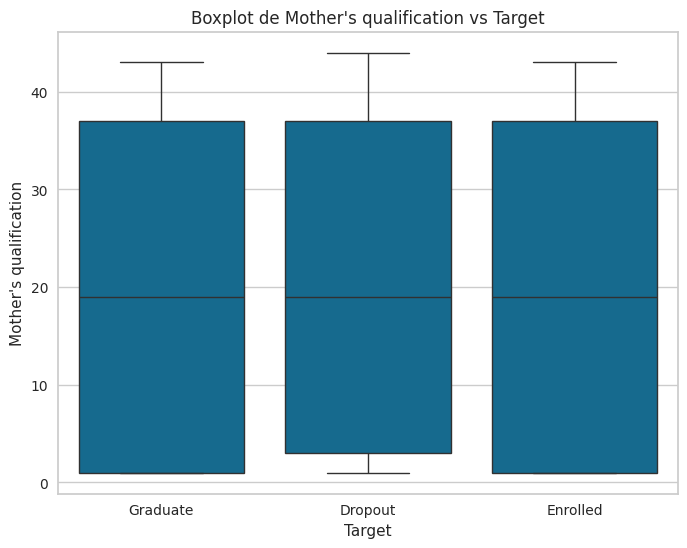

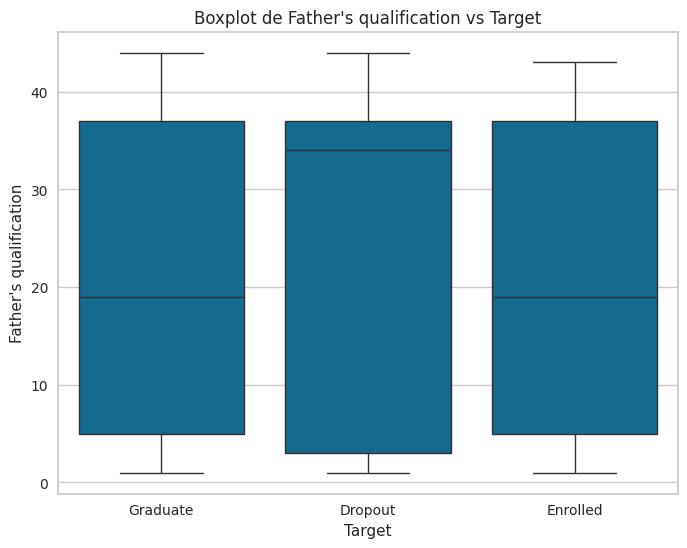

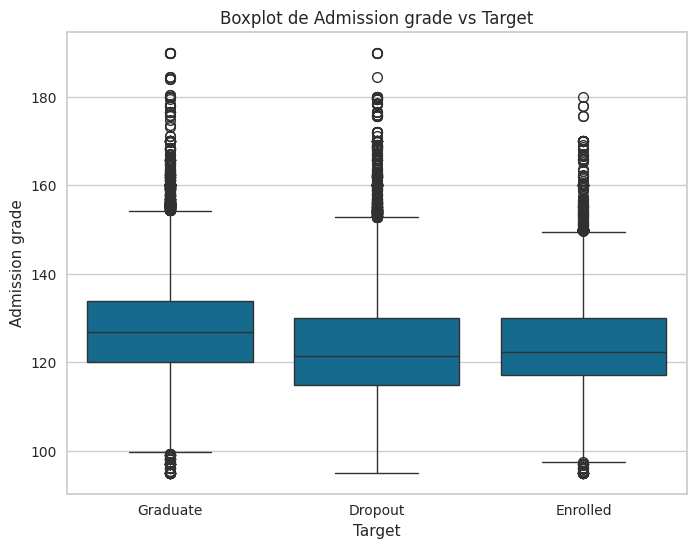

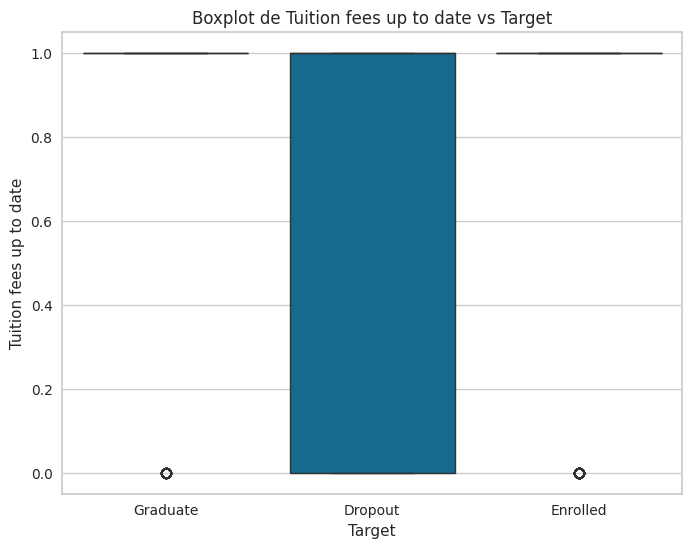

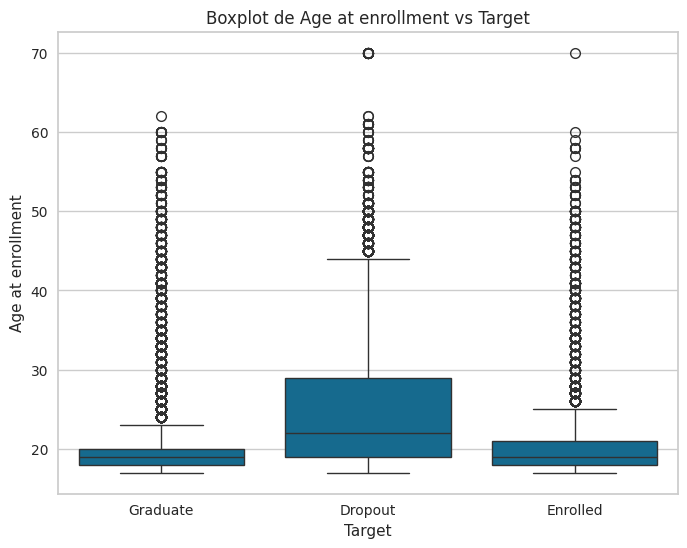

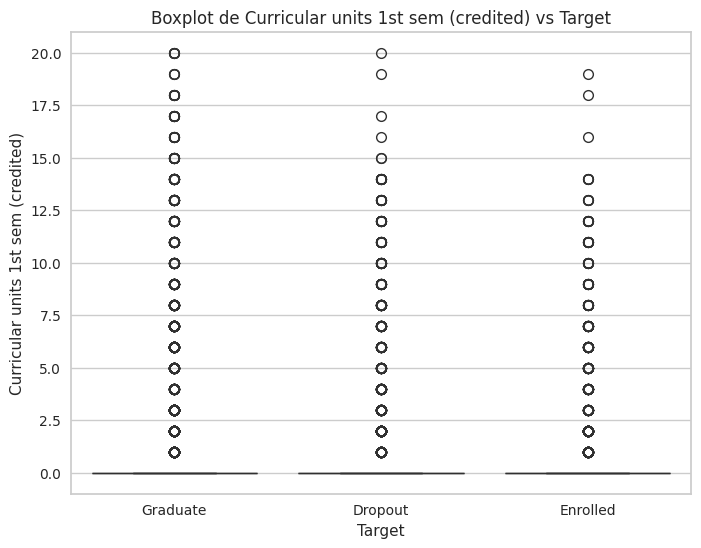

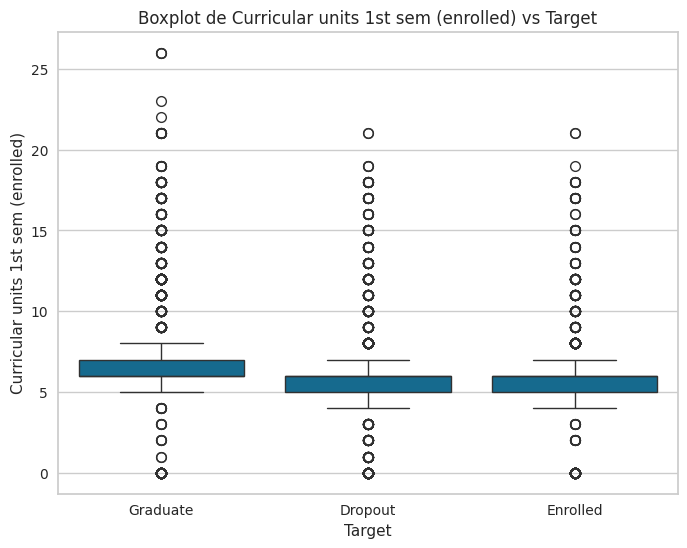

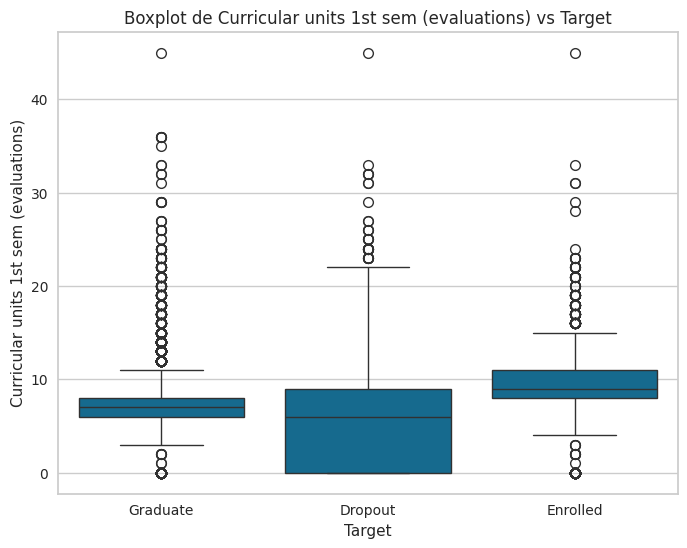

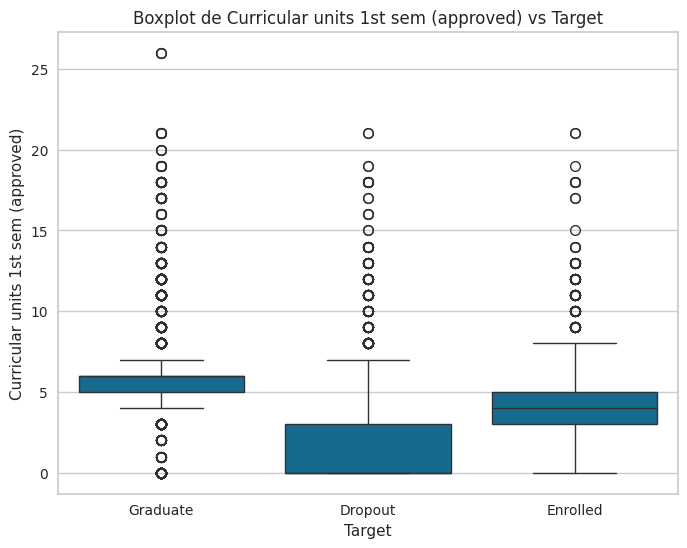

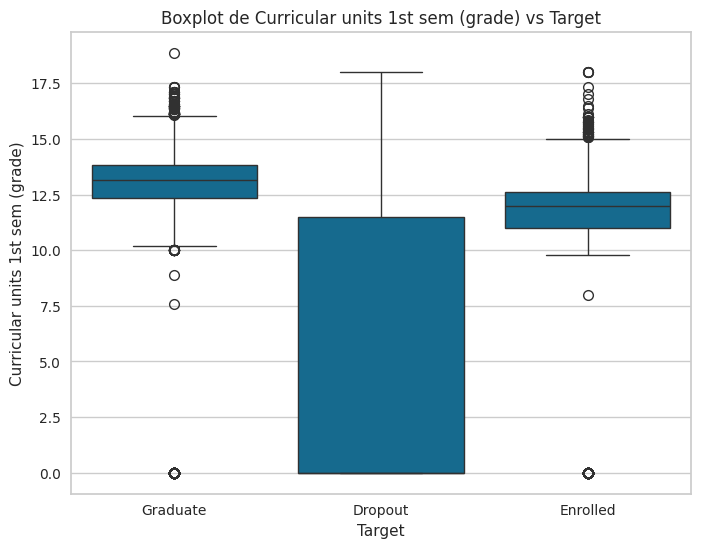

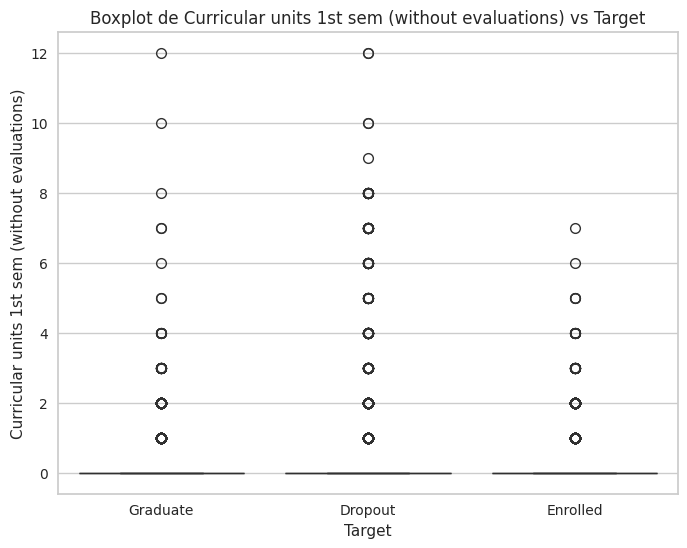

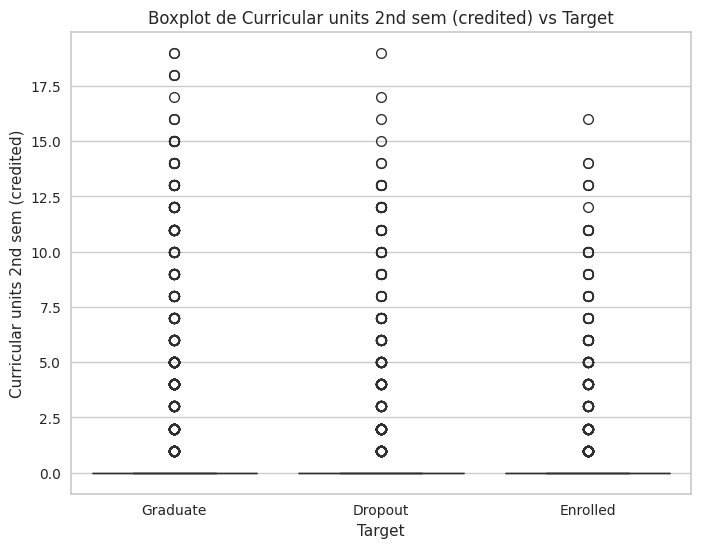

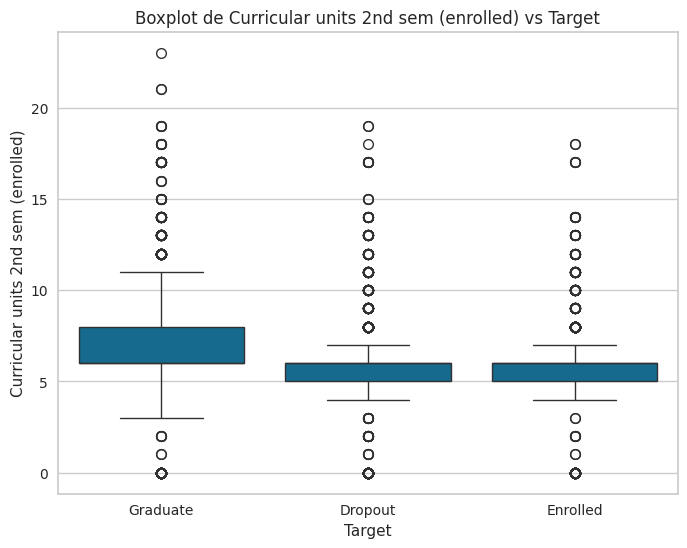

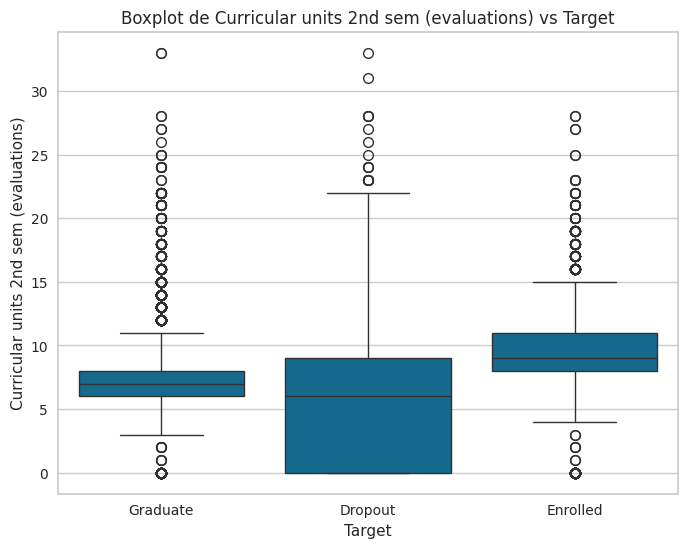

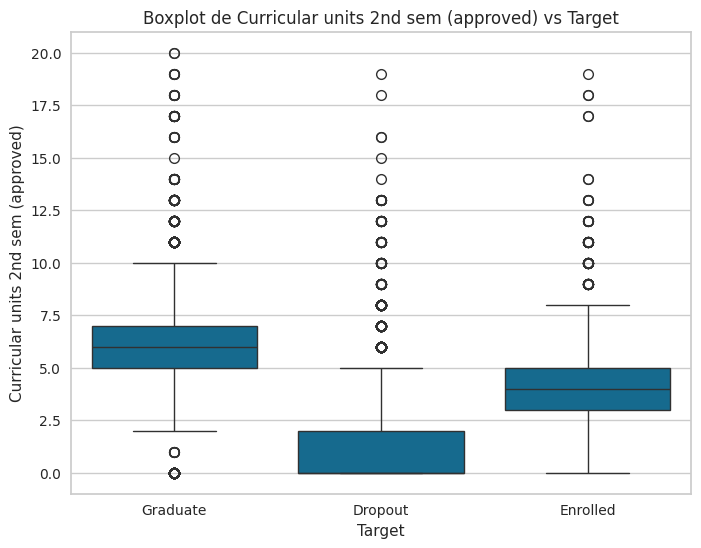

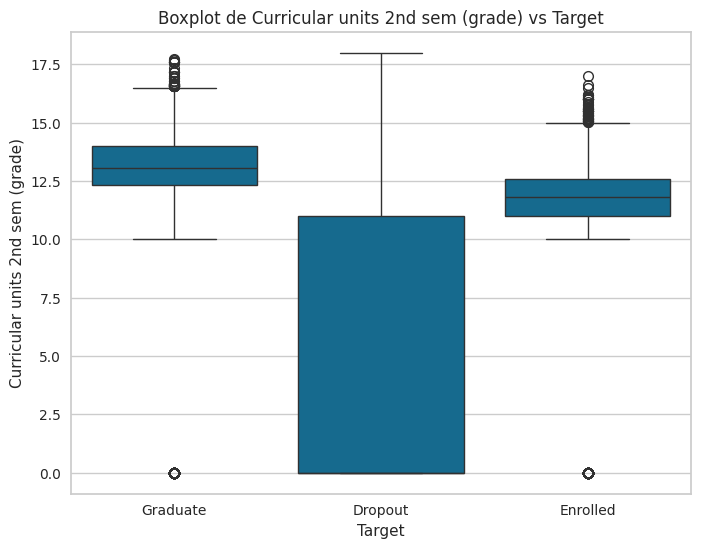

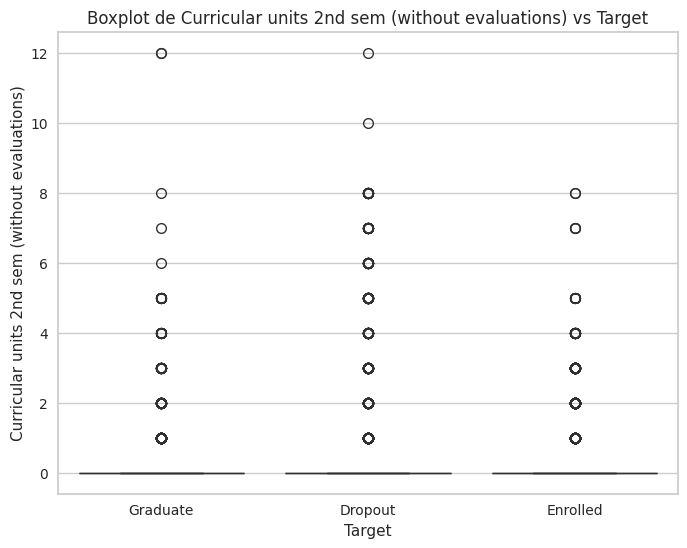

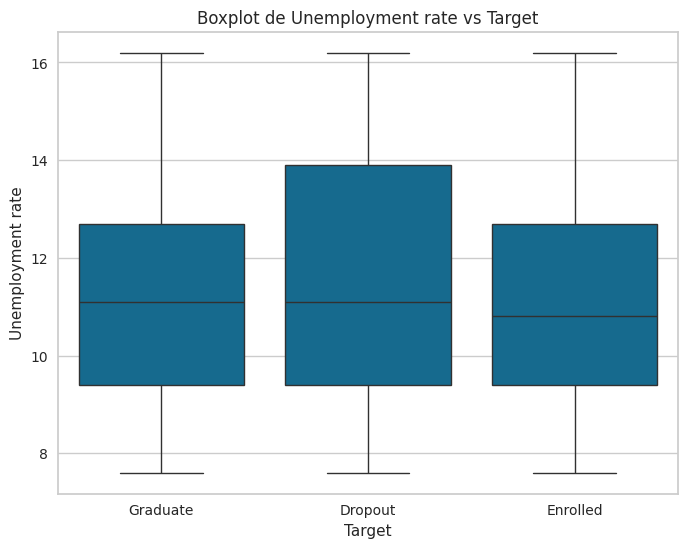

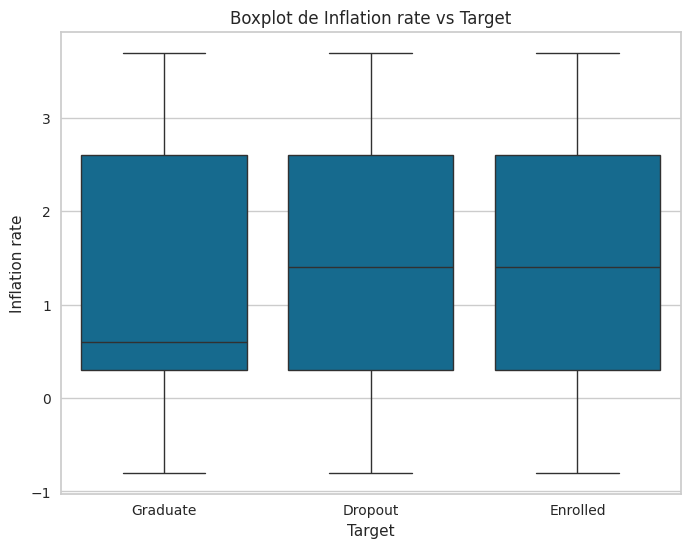

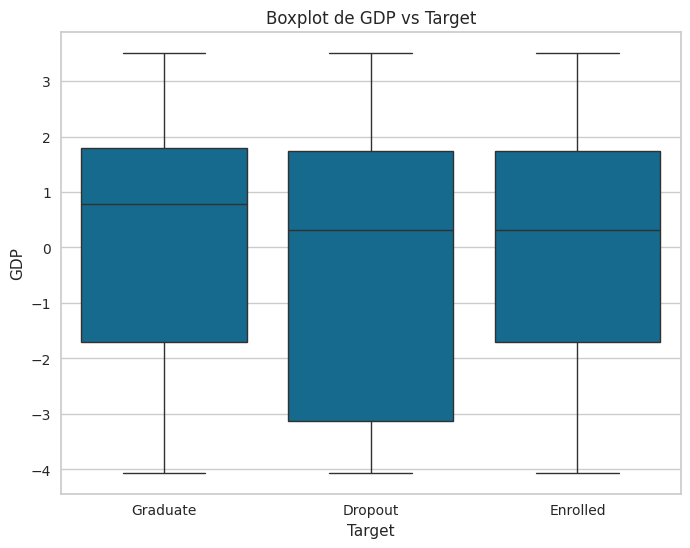

In [16]:
# Configurar una fuente alternativa
plt.rcParams['font.family'] = 'DejaVu Sans'

# Creación de boxplots para cada variable cuantitativa vs 'Target'
for k in cuantitativas:
    plt.figure(figsize=(8,6))
    sns.boxplot(x="Target", y=k, data=df)
    plt.title(f"Boxplot de {k} vs Target")
    plt.show()

### Interpretación General de los Boxplots

### 1. Estado Civil vs. Target  
El estado civil no presenta una variación significativa en relación con el Target. Los grupos de graduados, desertores y matriculados muestran distribuciones muy similares, lo que sugiere que no existe una correlación fuerte entre el estado civil y el rendimiento académico.

### 2. Modo de Aplicación vs. Target  
Los estudiantes que se gradúan tienden a haber utilizado modos de aplicación más bajos en comparación con los que desertan o permanecen matriculados, aunque se observan algunos valores atípicos elevados en los graduados. Esto podría indicar que ciertos modos de aplicación están asociados con un mayor riesgo de deserción.

### 3. Orden de Aplicación vs. Target  
El orden de aplicación se concentra principalmente entre 1 y 3 en todos los grupos, con algunos valores atípicos más altos. No se perciben diferencias significativas entre los estudiantes graduados, desertores o matriculados en cuanto al orden de aplicación.

### 4. Curso vs. Target  
No se evidencian diferencias significativas en los cursos tomados por los estudiantes de los tres grupos, presentando distribuciones bastante uniformes.

### 5. Asistencia Diurna/Nocturna vs. Target  
La distribución de la asistencia entre estudiantes diurnos y nocturnos es similar para todos los grupos. No se observa una diferencia clara entre graduados, desertores y matriculados en esta variable.

### 6. Calificación Previa vs. Target  
Las calificaciones previas son bastante homogéneas entre los diferentes grupos de estudiantes. No se aprecian grandes diferencias en las calificaciones previas entre graduados, desertores o matriculados.

### 7. Calificación Previa (Nota) vs. Target  
Se observa una ligera diferencia en las calificaciones previas, donde los desertores muestran un rango intercuartil ligeramente mayor, lo que podría indicar una mayor variabilidad en el rendimiento académico previo de los estudiantes que terminan desertando.

### 8. Nacionalidad vs. Target  
La nacionalidad no parece ser un factor diferenciador significativo entre los tres grupos, ya que las distribuciones son similares entre graduados, desertores y matriculados.

### 9. Cualificación de la Madre y el Padre vs. Target  
La cualificación de los padres es bastante uniforme entre los tres grupos, sin que se observe una influencia notable del nivel educativo de los padres sobre el Target.

### 10. Ocupación de la Madre y el Padre vs. Target  
La ocupación de los padres presenta una dispersión similar entre los tres grupos, sugiriendo que no tiene un impacto significativo en la probabilidad de que el estudiante se gradúe, deserte o permanezca matriculado.

### 11. Edad al Inscribirse vs. Target  
Se observa una diferencia más marcada en la edad al momento de la inscripción, con una mayor variabilidad y algunos valores extremos entre los desertores. Esto podría indicar que los estudiantes de mayor edad tienen una mayor probabilidad de desertar.

### 12. Unidades Curriculares (Acreditadas, Inscritas, Evaluadas, Aprobadas) vs. Target (Primer y Segundo Semestre)  
Los desertores tienden a tener menos créditos aprobados en el primer y segundo semestre en comparación con graduados y matriculados. Además, muestran una mayor variabilidad en las evaluaciones, lo que sugiere que un bajo rendimiento en estas podría estar relacionado con la deserción. Por otro lado, los graduados consistentemente presentan más unidades curriculares aprobadas y un mejor rendimiento en términos de calificaciones.

### 13. Tasa de Desempleo vs. Target  
El desempleo parece ser ligeramente más alto entre los desertores, aunque las diferencias entre los grupos no son drásticas. Esto podría indicar que el entorno económico tiene algún impacto en la probabilidad de deserción.

### 14. Tasa de Inflación vs. Target  
La tasa de inflación presenta una distribución similar en todos los grupos, lo que indica que no hay una relación fuerte entre la inflación y el Target.

### 15. PIB vs. Target  
En el análisis del PIB, se observa que los desertores tienden a provenir de regiones con una mayor variabilidad en el PIB, mientras que los graduados y matriculados parecen provenir de regiones con un PIB más estable y ligeramente superior.

## Conclusiones Finales

**Factores relevantes:** Variables como el Modo de Aplicación, las calificaciones previas, la edad de inscripción, el desempeño académico en términos de unidades curriculares (aprobadas y evaluadas), y el PIB parecen estar significativamente asociadas con el Target.

**Factores menos influyentes:** Variables como el estado civil, la asistencia diurna/nocturna, la nacionalidad y las cualificaciones de los padres no muestran una relación clara con el Target.

**Riesgo de deserción:** Los estudiantes de mayor edad al inscribirse, con menor rendimiento en evaluaciones, y aquellos provenientes de regiones con mayor variabilidad en el PIB parecen tener un mayor riesgo de deserción.

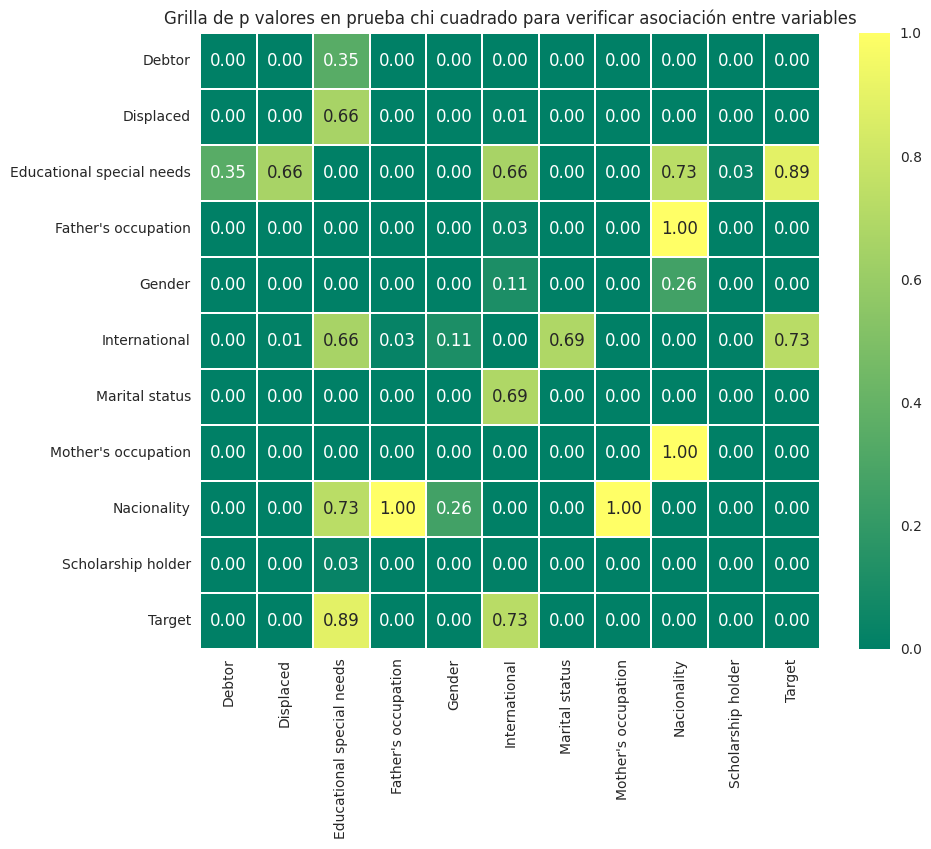

In [17]:
from main import asociacion

grilla_asociacion, grilla_asociacion2 = asociacion(df)

1. **Debtor (Deudor)**:
   - *p-valor = 0.00*: Ser deudor tiene una clara influencia sobre el estado académico del estudiante, lo que sugiere que tener deudas afecta si el estudiante se gradúa, abandona o sigue matriculado.
   
2. **Displaced (Desplazado)**:
   - *p-valor = 0.00*: Ser desplazado también está estrechamente relacionado con el estado académico, lo que indica que los estudiantes desplazados tienden a caer más en alguna de las categorías de graduado, desertado o matriculado.

3. **Educational Special Needs (Necesidades Educativas Especiales)**:
   - *p-valor = 0.89*: No parece haber una relación significativa entre tener necesidades educativas especiales y el estado académico del estudiante, lo que sugiere que esta variable no impacta de manera relevante en los resultados académicos.

4. **Father's Occupation (Ocupación del Padre)**:
   - *p-valor = 0.00*: La ocupación del padre sí tiene un impacto significativo en el estado académico del estudiante.

5. **Gender (Género)**:
   - *p-valor = 0.00*: El género del estudiante influye de manera importante en su estado académico, es decir, si se gradúa, se retira o permanece matriculado.

6. **International (Estudiante Internacional)**:
   - *p-valor = 0.73*: Ser estudiante internacional no parece afectar de manera importante el estado académico, ya que no se encuentra una relación significativa.

7. **Marital Status (Estado Civil)**:
   - *p-valor = 0.00*: El estado civil del estudiante está significativamente relacionado con su estado académico.

8. **Mother's Occupation (Ocupación de la Madre)**:
   - *p-valor = 0.00*: Al igual que la ocupación del padre, la ocupación de la madre también influye de manera importante en el estado académico del estudiante.

9. **Nationality (Nacionalidad)**:
   - *p-valor = 0.73*: No se encontró una relación significativa entre la nacionalidad y el estado académico del estudiante.

10. **Scholarship Holder (Becado)**:
    - *p-valor = 0.00*: Ser becado tiene una influencia significativa en el estado académico, lo que indica que los estudiantes con becas tienden a estar en una de las categorías de graduado, desertado o matriculado.

### Conclusión

Las variables con **relación significativa** con el estado académico (**Target**) son:
- **Deudor**
- **Desplazado**
- **Ocupación del padre**
- **Género**
- **Estado civil**
- **Ocupación de la madre**
- **Becado**

Estas variables parecen influir en si un estudiante se gradúa, abandona o sigue matriculado, mientras que variables como **necesidades educativas especiales**, **ser estudiante internacional** y **nacionalidad** no parecen ser factores importantes en este contexto.


## Base modelo

In [7]:
le = LabelEncoder()
df["Target"] = le.fit_transform(df["Target"])

In [8]:
base_modelo = df.copy()
base_modelo["Target"] = df["Target"].copy()
base_modelo["Target"] = base_modelo["Target"].map(int)
base_modelo.head(3)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,2
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,0
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,0


## AUTOML

In [9]:
column_types = base_modelo.dtypes
print(column_types)

Marital status                                     object
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                        object
Mother's qualification                              int64
Father's qualification                              int64
Mothers occupation                                 object
Fathers occupation                                 object
Admission grade                                   float64
Displaced                                          object
Educational special needs                          object
Debtor                                             object
Tuition fees up to date                             int64
Gender        

In [10]:
formatos = pd.DataFrame(base_modelo.dtypes).reset_index()
formatos.columns = ["Variable", "Formato"]

# Identificar variables cuantitativas y categóricas
cuantitativas_bm = [x for x in formatos.loc[formatos["Formato"] != "object", "Variable"] if x not in ["id", "Target"]]
categoricas_bm = [x for x in formatos.loc[formatos["Formato"] == "object", "Variable"] if x not in ["id", "Target"]]

In [11]:
# Asumiendo que 'base_modelo' es tu DataFrame principal

# Separar características y la variable objetivo
X = base_modelo.drop(columns=['Target'])
y = base_modelo['Target']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Codificación de variables categóricas
rare_encoder = RareLabelEncoder(tol=0.05, n_categories=2, variables=categoricas_bm)
X_train = rare_encoder.fit_transform(X_train)
X_test = rare_encoder.transform(X_test)

one_hot_encoder = OneHotEncoder(drop_last=True, variables=categoricas_bm)
X_train = one_hot_encoder.fit_transform(X_train)
X_test = one_hot_encoder.transform(X_test)

# Crear características matemáticas (suma, multiplicación)
math_transformer = MathFeatures(variables=cuantitativas_bm, func=['sum', 'prod'])
X_train = math_transformer.fit_transform(X_train)
X_test = math_transformer.transform(X_test)

# Crear características polinómicas (cuadráticas) y de interacción usando sklearn
poly_transformer = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_train_poly = poly_transformer.fit_transform(X_train[cuantitativas_bm])
X_test_poly = poly_transformer.transform(X_test[cuantitativas_bm])

# Concatenar las nuevas características polinómicas al conjunto de datos original
X_train = np.hstack([X_train, X_train_poly])
X_test = np.hstack([X_test, X_test_poly])

# Escalar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convertir de vuelta a DataFrame y añadir la columna 'Target'
X_train = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X_train.shape[1])])
X_train['Target'] = y_train.reset_index(drop=True)

X_test = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(X_test.shape[1])])
X_test['Target'] = y_test.reset_index(drop=True)

# Concatenar para usar en PyCaret
base_modelo = pd.concat([X_train, X_test], axis=0)

In [12]:
base_modelo.reset_index(drop=True, inplace=True)

exp_clf101 = setup(
    data=base_modelo,
    target='Target',
    session_id=123,
    train_size=0.7,
    numeric_features=[f'feature_{i}' for i in range(X_train.shape[1] - 1)],  # última columna es 'Target'
    fix_imbalance=True
)

,Description,Value
0,Session id,123
1,Target,Target
2,Target type,Multiclass
3,Original data shape,"(76518, 428)"
4,Transformed data shape,"(99147, 428)"
5,Transformed train set shape,"(76191, 428)"
6,Transformed test set shape,"(22956, 428)"
7,Numeric features,427
8,Preprocess,True
9,Imputation type,simple


In [13]:
top4_models = compare_models(sort='Accuracy', n_select=1)

In [14]:
# Entrenar el modelo base de LightGBM
trained_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8316,0.9426,0.8316,0.8308,0.8307,0.7300,0.7306
1,0.8217,0.9387,0.8217,0.8205,0.8197,0.7125,0.7141
2,0.8271,0.9429,0.8271,0.8272,0.8261,0.7221,0.7233
3,0.8329,0.9445,0.8329,0.8329,0.8319,0.7316,0.7327
4,0.8366,0.9443,0.8366,0.8359,0.8352,0.7372,0.7384
5,0.8267,0.9415,0.8267,0.8284,0.8268,0.7227,0.7234
6,0.8290,0.9454,0.8290,0.8295,0.8285,0.7258,0.7266
7,0.8325,0.9423,0.8325,0.8316,0.8309,0.7304,0.7317
8,0.8297,0.9434,0.8297,0.8270,0.8272,0.7254,0.7267


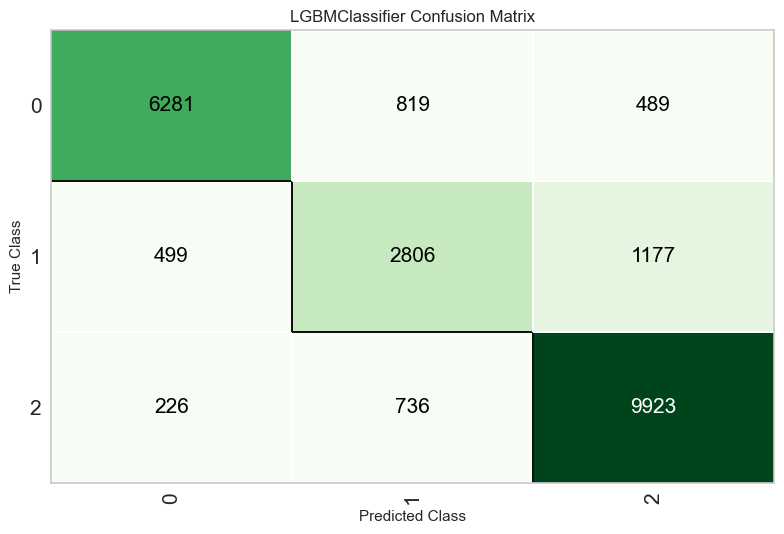

In [23]:
plot_model(trained_model, plot='confusion_matrix')

In [15]:
# Definir la cuadrícula de parámetros para la búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50,100,200],
    'max_depth': [3,5,7],
    'min_child_samples': [50,150,200]}

# Ajuste del modelo con optimización bayesiana
tuned_model = tune_model(
    estimator=trained_model, 
    custom_grid=param_grid, 
    search_library='scikit-optimize', 
    search_algorithm='bayesian', 
    fold=5
)

In [16]:
# Definir el nombre del archivo con el nombre del modelo para guardarlo
model_name = "lightgbm_try2"
file_name = f'{path}{model_name}_model.pkl'

# Guardar el modelo entrenado en un archivo con pickle
with open(file_name, 'wb') as model_file:
    pickle.dump(tuned_model, model_file)

print(f'Model {model_name} saved as {file_name}')

# Evaluar el modelo en el conjunto de prueba
predictions_test = predict_model(tuned_model, data=X_test)
predictions_train = predict_model(tuned_model, data=get_config('X_train'))

y_train = get_config('y_train')
y_test = get_config('y_test')

# Error de entrenamiento
train_accuracy = accuracy_score(y_train, predictions_train["prediction_label"])
print(f'Accuracy on training set for {model_name}: {train_accuracy}')

# Error de test
test_accuracy = accuracy_score(y_test, predictions_test["prediction_label"])
print(f'Accuracy on test set for {model_name}: {test_accuracy}')

# Finalizar el modelo
final_dt = finalize_model(tuned_model)

Model lightgbm_try2 saved as C:/Users/jesco/OneDrive - Universidad Santo Tomás/Documentos/Python/T3/lightgbm_try2_model.pkl


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8462,0.9550,0.8462,0.8460,0.8451,0.7526,0.7538


Accuracy on training set for lightgbm_try2: 0.8564280646727157
Accuracy on test set for lightgbm_try2: 0.3744119184526921


In [17]:
# Suponiendo que el conjunto de datos 'prueba' tiene las mismas columnas que X_test, excepto 'Target'
# Aplica las mismas transformaciones que se hicieron en X_train y X_test

# Codificación de variables categóricas en 'prueba'
prueba = rare_encoder.transform(prueba)
prueba = one_hot_encoder.transform(prueba)

# Crear características matemáticas en 'prueba'
prueba = math_transformer.transform(prueba)

# Crear características polinómicas en 'prueba'
prueba_poly = poly_transformer.transform(prueba[cuantitativas_bm])

# Concatenar las características polinómicas a 'prueba'
prueba = np.hstack([prueba, prueba_poly])

# Escalar las características en 'prueba'
prueba = scaler.transform(prueba)

# Convertir 'prueba' de vuelta a un DataFrame (sin la columna 'Target')
prueba_df = pd.DataFrame(prueba, columns=[f'feature_{i}' for i in range(prueba.shape[1])])

In [18]:
prueba_df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_417,feature_418,feature_419,feature_420,feature_421,feature_422,feature_423,feature_424,feature_425,feature_426
0,-0.903637,-0.522903,0.278403,0.304834,-0.307304,0.786956,-1.096119,-1.505896,2.130016,-2.884440,...,-0.086278,-0.129104,-0.082721,0.049159,0.843436,-1.073114,0.504426,-0.785362,0.032054,-0.877084
1,-0.903637,-0.522903,0.134044,0.304834,-0.307304,-0.398485,-1.226048,-0.298544,-0.706272,0.346688,...,-0.086278,-0.129104,-0.082721,0.049159,-0.263318,-0.437982,0.925386,-0.722584,0.367655,-0.195766
2,-0.903637,-0.522903,0.134044,0.304834,-0.307304,-1.310363,-1.226048,-0.298544,-0.889516,0.346688,...,-0.086278,-0.129104,-0.082721,0.049159,1.587176,1.716656,-2.215057,1.016606,-2.545979,2.249198
3,1.673291,-0.522903,0.083904,0.304834,4.114632,-0.216109,-1.226048,-0.298544,0.369286,0.346688,...,-0.086278,-0.129104,-0.082721,0.049159,-0.958993,-0.097838,1.249799,-0.350564,1.225069,1.428474
4,1.373649,-0.522903,0.372071,0.304834,-0.307304,-2.039865,-1.226048,0.908807,-1.542818,0.346688,...,1.477190,2.654926,6.648470,0.717949,-1.298134,0.330275,0.189874,0.765493,0.279644,-0.979924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51007,-0.903637,0.291962,-4.861759,0.304834,-0.307304,-0.398485,1.177647,0.908807,-0.052970,0.346688,...,-0.086278,-0.129104,-0.082721,0.049159,1.587176,1.716656,-2.215057,1.016606,-2.545979,2.249198
51008,1.373649,-0.522903,0.068477,0.304834,1.787297,0.066573,-0.056683,0.908807,1.165997,-2.884440,...,-0.086278,-0.129104,-0.082721,0.049159,-0.814324,-1.269576,-0.978704,-0.657480,0.665040,0.918771
51009,-0.903637,-0.522903,-4.861759,0.304834,-0.307304,-0.489673,-1.226048,-1.505896,-0.395555,-2.884440,...,-0.086278,-0.129104,-0.082721,0.049159,1.587176,1.716656,-2.215057,1.016606,-2.545979,2.249198
51010,-0.903637,1.106828,0.428822,0.304834,-0.307304,-0.033734,-0.056683,-0.298544,0.074504,-2.884440,...,-0.086278,-0.129104,-0.082721,0.049159,-1.298134,0.330275,0.189874,0.765493,0.279644,-0.979924


In [20]:
# Realizar predicciones usando el modelo final
# final_dt = load_model(file_name)  # Asegúrate de cargar tu modelo entrenado
predictions = predict_model(final_dt, data=prueba_df)

predictions["Target"] = le.inverse_transform(predictions['prediction_label'])
prueba_df["id"] = prueba_id.reset_index(drop=True)
result = pd.DataFrame({
    'id': prueba_df["id"],  # Asegúrate de que la columna 'id' esté en 'prueba'
    'Target': predictions['Target']
})

# Guardar el resultado en un archivo CSV con el nombre del modelo
result_file_name = f'{path}t3_{model_name}.csv'
result.to_csv(result_file_name, index=False, sep=",")

print(f'Result saved as {result_file_name}')

Result saved as C:/Users/jesco/OneDrive - Universidad Santo Tomás/Documentos/Python/T3/t3_lightgbm_try2.csv


In [ ]:
# import pickle
# with open(path + 'LGBMClassifier_model_1.pkl', 'wb') as model_file:
#     pickle.dump(trained_model, model_file)